# [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) simple exploration

## Intelligence

We will give a try to transfer learning, using `Keras`.  
Specifically, we will reuse model `XXX`, and perform standard data augmentation using [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/).

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import re
# import pandas as pd
import time
import pickle
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

# from IAFlash.helpers import DataHandler, ImageWorker # needs correct working directory

Using TensorFlow backend.


### Variables

In [2]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwTrueresampleFilter0')
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))
data_format = 'channels_last'
nbClass = 196

# image processing
edge = int(re.findall('edge([0-9]*)',pathToDataDir)[0])
if 'bwTrue' in pathToDataDir:
    mode = 'grayscale'
elif 'bwFalse' in pathToDataDir:
    mode = 'rgb'
else:
    raise ValueError('color mode not undestood from data directory name')
    
# learning params
# IAH: get the parameters from cells bellow

# seed
seed = 8
np.random.seed(seed)

### Intelligence

The [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/) object allows to augment data easily. Depending on the method used, data augmentation can be done once-for-all or on-the-fly. We will choose on-the-fly augmentation to avoid storing to large data.

In [3]:
# prepare a dataset augmenter
batch_size = 32

# NB: only train data need augmentation
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   zca_whitening=False, # explore this later
                                   zca_epsilon=1e-06,
                                   rotation_range=20, # 0
                                   width_shift_range=0.0,
                                   height_shift_range=0.0,
                                   shear_range=0.0,
                                   zoom_range=0.0,
                                   channel_shift_range=0.0,
                                   fill_mode='constant', #'nearest',
                                   cval=0.0,
                                   horizontal_flip=True, # False
                                   vertical_flip=False,
                                   rescale=1./255, # None
                                   preprocessing_function=None,
                                   data_format=data_format)

train_generator = train_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Train'), # "it should contain one subdirectory per class"
                                                    target_size=(edge, edge),
                                                    color_mode=mode,
                                                    classes=None, # will infer from the directory structure
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=seed,
                                                    save_to_dir=None, # we will observe directly here
                                                    save_prefix=None,
                                                    save_format=None,
                                                    follow_links=False,
                                                    interpolation='nearest')

# NB: validation data use `ImageDataGenerator` for the convenance of directory parsing
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Validation'), # "it should contain one subdirectory per class"
                                                        target_size=(edge, edge),
                                                        color_mode=mode,
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

Found 8144 images belonging to 196 classes.
Found 1600 images belonging to 196 classes.


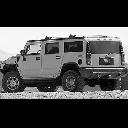

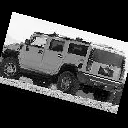

In [4]:
# example of data augmentation
i = 1
im = Image.open(os.path.join(pathToDataDir, 'Train', train_generator.filenames[i]))
x_im = np.array(im).reshape((edge, edge, 1))
x_im_t = train_datagen.random_transform(x_im, seed=None).reshape(edge, edge)
im_t = Image.fromarray(x_im_t)

display(im)
display(im_t)

In [5]:
# build a model

model = Sequential()
model.add(Conv2D(input_shape=train_generator.image_shape,
                 filters=1,
                 kernel_size=9,
                 strides=1,
                 padding='same',
                 data_format=train_generator.data_format,
                 dilation_rate=1,
                 activation=None, # explicit it later
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3),
                       strides=None,
                       padding='same',
                       data_format=train_generator.data_format))
model.add(Flatten())
model.add(Dense(train_generator.num_classes))
model.add(Activation('softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 1)       82        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 1)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1849)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               362600    
_________________________________________________________________
activation_2 (Activation)    (None, 196)               0         
Total params: 362,682
Trainable params: 362,682
Non-trainable params: 0
_________________________________________________________________


In [6]:
# set compilation params

loss = 'categorical_crossentropy'

#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optim = 'adam'
#optim = Adamax()

metric = ['accuracy']

model.compile(loss=loss,
              optimizer=optim,
              metrics=metric)

In [ ]:
# set fitting params

epochs = 10

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=1)
checkpoint = ModelCheckpoint(os.path.join(pathToIntellDir, 'model_v0.hdf5'),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             period=1)
reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.1,
                             patience=4,
                             verbose=1)

In [7]:
# train the model

model_history = model.fit_generator(train_generator,
                                    epochs=epochs,
                                    steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
                                    validation_data=validation_generator,
                                    validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
                                    callbacks=[earlystop,checkpoint,reducelr])

Epoch 1/10
253/254 [============================>.] - ETA: 0s - loss: 5.2797 - acc: 0.0057
Epoch 00001: val_loss improved from inf to 5.27409, saving model to /Users/arthur/Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/model_v0.hdf5
254/254 [==============================] - 89s 349ms/step - loss: 5.2797 - acc: 0.0057 - val_loss: 5.2741 - val_acc: 0.0075
Epoch 2/10
253/254 [============================>.] - ETA: 0s - loss: 5.2391 - acc: 0.0104
Epoch 00002: val_loss improved from 5.27409 to 5.22060, saving model to /Users/arthur/Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/model_v0.hdf5
254/254 [==============================] - 90s 352ms/step - loss: 5.2391 - acc: 0.0103 - val_loss: 5.2206 - val_acc: 0.0069
Epoch 3/10
253/254 [============================>.] - ETA: 0s - loss: 5.1140 - acc: 0.0253
Epoch 00003: val_loss improved from 5.22060 to 5.19752, saving model to /Users/arthur/Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/model_v0.hdf5
254/254 [=====================

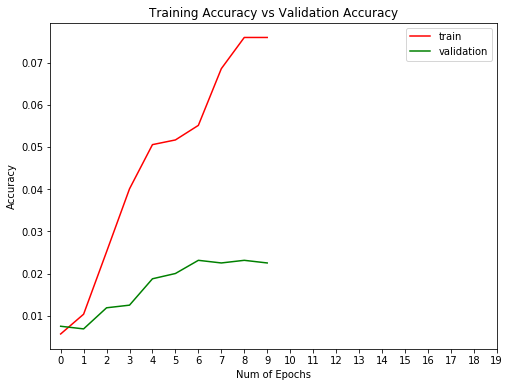

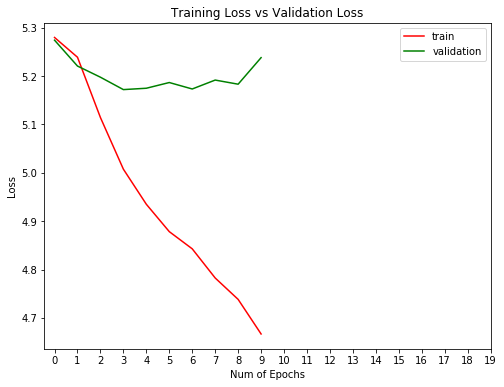

In [11]:
# plot the learning performance

# IAH: clean that!

plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

# plt.figure(2)
# plt.plot(model_history.history['mean_squared_error'],'r')
# plt.plot(model_history.history['val_mean_squared_error'],'g')
# plt.xticks(np.arange(0, 20, 1.0))
# plt.rcParams['figure.figsize'] = (8, 6)
# plt.xlabel("Num of Epochs")
# plt.ylabel("MSE")
# plt.title("Training Loss vs Validation Loss")
# plt.legend(['train','validation'])
 
plt.show()

In [12]:
# assess performance aon validation set

# IAH: check if it is the correct way
pred = model.predict_generator(validation_generator,
                               steps=None,
                               max_queue_size=10,
                               workers=1,
                               use_multiprocessing=False,
                               verbose=1)
# predicted = np.argmax(pred, axis=1)

50/50 [==============================] - 6s 115ms/step


In [31]:
i,K = 101,10

print(validation_generator.classes[i])
pred_i = pred[i,:]
argsort_i = np.argsort(pred_i)[::-1]
for k in range(K):
    print(argsort_i[k],pred_i[argsort_i[k]])

13
131 0.0175474
190 0.0145975
108 0.0136319
119 0.0130766
96 0.0124505
139 0.0115525
171 0.0114581
173 0.0111281
84 0.0103347
191 0.01014
